## Lab 2
### Part 2: Dealing with overfitting

Today we work with [Fashion-MNIST dataset](https://github.com/zalandoresearch/fashion-mnist) (*hint: it is available in `torchvision`*).

Your goal for today:
1. Train a FC (fully-connected) network that achieves >= 0.885 test accuracy.
2. Cause considerable overfitting by modifying the network (e.g. increasing the number of network parameters and/or layers) and demonstrate in in the appropriate way (e.g. plot loss and accurasy on train and validation set w.r.t. network complexity).
3. Try to deal with overfitting (at least partially) by using regularization techniques (Dropout/Batchnorm/...) and demonstrate the results.

__Please, write a small report describing your ideas, tries and achieved results in the end of this file.__

*Note*: Tasks 2 and 3 are interrelated, in task 3 your goal is to make the network from task 2 less prone to overfitting. Task 1 is independent from 2 and 3.

*Note 2*: We recomment to use Google Colab or other machine with GPU acceleration.

In [42]:
import torch
import torch.nn as nn
import torchvision
import torchvision.transforms as transforms
import torchsummary
from IPython.display import clear_output
from matplotlib import pyplot as plt
from matplotlib.pyplot import figure
import numpy as np
import os


device = 'cuda:0' if torch.cuda.is_available() else 'cpu'

In [43]:
# Technical function
def mkdir(path):
    if not os.path.exists(root_path):
        os.mkdir(root_path)
        print('Directory', path, 'is created!')
    else:
        print('Directory', path, 'already exists!')

root_path = 'fmnist'
mkdir(root_path)

Directory fmnist already exists!


In [44]:
download = True
train_transform = transforms.ToTensor()
test_transform = transforms.ToTensor()
transforms.Compose((transforms.ToTensor()))


fmnist_dataset_train = torchvision.datasets.FashionMNIST(root_path,
                                                        train=True,
                                                        transform=train_transform,
                                                        target_transform=None,
                                                        download=download)
fmnist_dataset_test = torchvision.datasets.FashionMNIST(root_path,
                                                       train=False,
                                                       transform=test_transform,
                                                       target_transform=None,
                                                       download=download)

In [45]:
train_loader = torch.utils.data.DataLoader(fmnist_dataset_train,
                                           batch_size=128,
                                           shuffle=True,
                                           num_workers=2)
test_loader = torch.utils.data.DataLoader(fmnist_dataset_test,
                                          batch_size=256,
                                          shuffle=False,
                                          num_workers=2)

In [46]:
len(fmnist_dataset_test)

10000

In [47]:
for img, label in train_loader:
    print(img.shape)
    #print(img)
    print(label.shape)
    print(label.size(0))
    break

torch.Size([128, 1, 28, 28])
torch.Size([128])
128


### Task 1
Train a network that achieves $\geq 0.885$ test accuracy. It's fine to use only Linear (`nn.Linear`) layers and activations/dropout/batchnorm. Convolutional layers might be a great use, but we will meet them a bit later.

In [73]:
class TinyNeuralNetwork(nn.Module):
    def __init__(self, input_shape=28*28, num_classes=10, input_channels=1):
        super(self.__class__, self).__init__()
        self.model = nn.Sequential(
            nn.Flatten(), # This layer converts image into a vector to use Linear layers afterwards
            nn.Linear(784, 256),
            nn.ReLU(),
            nn.Linear(256, 128),
            nn.ReLU(),
            nn.BatchNorm1d(128),
            nn.Linear(128, 10),
            nn.LogSoftmax(1)
        )

    def forward(self, inp):
        out = self.model(inp)
        return out

In [74]:
torchsummary.summary(TinyNeuralNetwork().to(device), (28*28,))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
           Flatten-1                  [-1, 784]               0
            Linear-2                  [-1, 256]         200,960
              ReLU-3                  [-1, 256]               0
            Linear-4                  [-1, 128]          32,896
              ReLU-5                  [-1, 128]               0
       BatchNorm1d-6                  [-1, 128]             256
            Linear-7                   [-1, 10]           1,290
        LogSoftmax-8                   [-1, 10]               0
Total params: 235,402
Trainable params: 235,402
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/backward pass size (MB): 0.01
Params size (MB): 0.90
Estimated Total Size (MB): 0.91
----------------------------------------------------------------


Your experiments come here:

In [75]:
from sklearn.metrics import accuracy_score

model = TinyNeuralNetwork().to(device)
opt = torch.optim.Adam(model.parameters(), lr = 1e-3)
loss_func = nn.CrossEntropyLoss()
epochs = 12



for i in range(epochs):
    for x_batch, y_batch in train_loader:
        opt.zero_grad()
        pred = model.forward(x_batch.to(device))
        loss = loss_func(pred, y_batch.to(device))
        loss.backward()
        opt.step()

model.eval()



def accuracy(model):
    accuracy_list = []
    for x_test, y_test in test_loader:
        pred = model(x_test.to(device))
        accuracy_list.append(accuracy_score(y_test.cpu(), pred.cpu().argmax(-1)))

    return np.mean(accuracy_list)


print(f"accuracy score: {accuracy(model)}")

accuracy score: 0.885546875


### Task 2: Overfit it.
Build a network that will overfit to this dataset. Demonstrate the overfitting in the appropriate way (e.g. plot loss and accurasy on train and test set w.r.t. network complexity).

*Note:* you also might decrease the size of `train` dataset to enforce the overfitting and speed up the computations.

In [88]:
class OverfittingNeuralNetwork(nn.Module):
    def __init__(self, input_shape=28*28, num_classes=10, input_channels=1):
        super(self.__class__, self).__init__()
        self.model = nn.Sequential(
            nn.Flatten(), # This layer converts image into a vector to use Linear layers afterwards
            nn.Linear(784, 256),
            nn.ReLU(),
            nn.Linear(256, 256),
            nn.ReLU(),
            nn.Linear(256, 128),
            nn.ReLU(),
            nn.Linear(128, 10),
            nn.LogSoftmax(1)
        )

    def forward(self, inp):
        out = self.model(inp)
        return out

In [89]:
torchsummary.summary(OverfittingNeuralNetwork().to(device), (28*28,))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
           Flatten-1                  [-1, 784]               0
            Linear-2                  [-1, 256]         200,960
              ReLU-3                  [-1, 256]               0
            Linear-4                  [-1, 256]          65,792
              ReLU-5                  [-1, 256]               0
            Linear-6                  [-1, 128]          32,896
              ReLU-7                  [-1, 128]               0
            Linear-8                   [-1, 10]           1,290
        LogSoftmax-9                   [-1, 10]               0
Total params: 300,938
Trainable params: 300,938
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/backward pass size (MB): 0.02
Params size (MB): 1.15
Estimated Total Size (MB): 1.17
-------------------------------------------

In [99]:
fmnist_dataset_train_short, _ = torch.utils.data.random_split(fmnist_dataset_train, [10000, 50000])


train_short_loader = torch.utils.data.DataLoader(fmnist_dataset_train_short,
                                           batch_size=256,
                                           shuffle=True,
                                           num_workers=2)

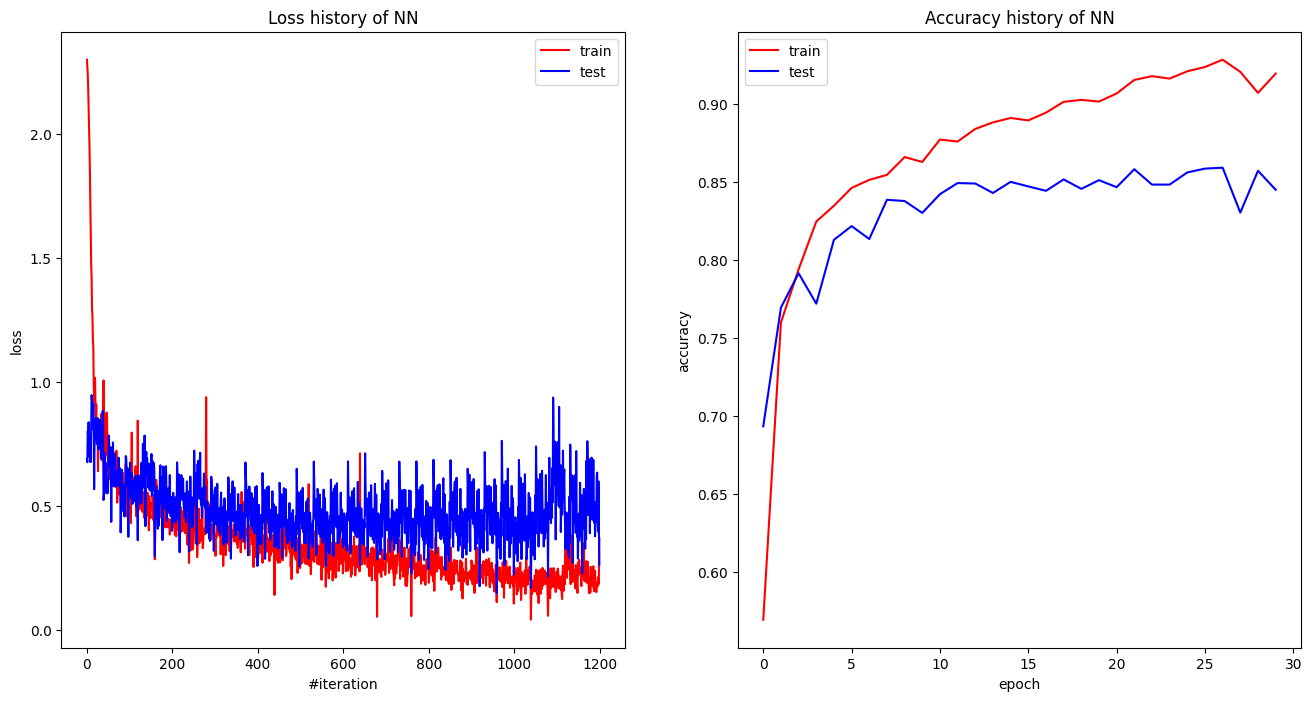

In [100]:
model = OverfittingNeuralNetwork().to(device)
opt = torch.optim.Adam(model.parameters(), lr = 1e-3)
loss_func = nn.CrossEntropyLoss()
epochs = 30



train_loss_history = []
test_loss_history = []
train_accuracy_history = []
test_accuracy_history = []
for i in range(epochs):
    model.train()
    accuracy_list = []
    for x_batch, y_batch in train_short_loader:
        opt.zero_grad()

        pred = model.forward(x_batch.to(device))
        accuracy_list.append(accuracy_score(y_batch.cpu(), pred.cpu().argmax(-1)))

        loss = loss_func(pred, y_batch.to(device))
        train_loss_history.append(loss.cpu().detach().numpy())

        loss.backward()

        opt.step()

    model.eval()

    train_accuracy_history.append(np.mean(accuracy_list))
    accuracy_list = []
    for x_test, y_test in test_loader:
        pred = model(x_test.to(device))
        test_loss_history.append(loss_func(pred, y_test.to(device)).cpu().detach().numpy())
        accuracy_list.append(accuracy_score(y_test.cpu(), pred.cpu().argmax(-1)))
    test_accuracy_history.append(np.mean(accuracy_list))



fig, ax = plt.subplots(1, 2, figsize=(16, 8))
ax[0].plot(train_loss_history, 'r', label='train')
ax[0].plot(test_loss_history, 'b', label='test')
ax[0].set(title="Loss history of NN", xlabel="#iteration", ylabel="loss")
ax[0].legend()

ax[1].plot(train_accuracy_history, 'r', label='train')
ax[1].plot(test_accuracy_history, 'b', label='test')
ax[1].set(title="Accuracy history of NN", xlabel="epoch", ylabel="accuracy")
ax[1].legend();

### Task 3: Fix it.
Fix the overfitted network from the previous step (at least partially) by using regularization techniques (Dropout/Batchnorm/...) and demonstrate the results.

In [103]:
class FixedNeuralNetwork(nn.Module):
    def __init__(self, input_shape=28*28, num_classes=10, input_channels=1):
        super(self.__class__, self).__init__()
        self.model = nn.Sequential(
            nn.Flatten(), # This layer converts image into a vector to use Linear layers afterwards
            nn.Linear(784, 256),
            nn.ReLU(),
            nn.Dropout(),
            nn.Linear(256, 256),
            nn.ReLU(),
            nn.BatchNorm1d(256, momentum=0.5),
            nn.Linear(256, 128),
            nn.ReLU(),
            nn.Dropout(),
            nn.Linear(128, 10),
            nn.LogSoftmax(1)
        )

    def forward(self, inp):
        out = self.model(inp)
        return out

In [104]:
torchsummary.summary(FixedNeuralNetwork().to(device), (28*28,))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
           Flatten-1                  [-1, 784]               0
            Linear-2                  [-1, 256]         200,960
              ReLU-3                  [-1, 256]               0
           Dropout-4                  [-1, 256]               0
            Linear-5                  [-1, 256]          65,792
              ReLU-6                  [-1, 256]               0
       BatchNorm1d-7                  [-1, 256]             512
            Linear-8                  [-1, 128]          32,896
              ReLU-9                  [-1, 128]               0
          Dropout-10                  [-1, 128]               0
           Linear-11                   [-1, 10]           1,290
       LogSoftmax-12                   [-1, 10]               0
Total params: 301,450
Trainable params: 301,450
Non-trainable params: 0
-------------------------------

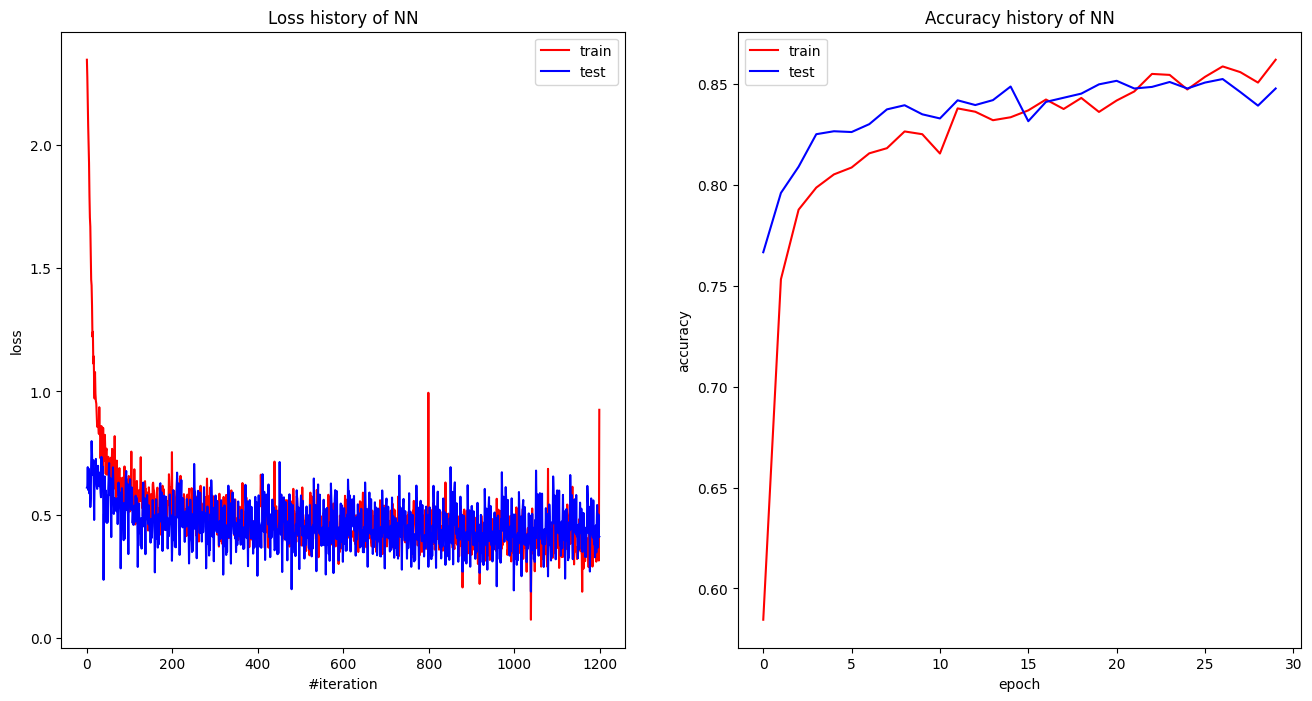

In [105]:
model = FixedNeuralNetwork().to(device)
opt = torch.optim.Adam(model.parameters(), lr = 1e-3)
loss_func = nn.CrossEntropyLoss()
epochs = 30



train_loss_history = []
test_loss_history = []
train_accuracy_history = []
test_accuracy_history = []
for i in range(epochs):
    model.train()
    accuracy_list = []
    for x_batch, y_batch in train_short_loader:
        opt.zero_grad()

        pred = model.forward(x_batch.to(device))
        accuracy_list.append(accuracy_score(y_batch.cpu(), pred.cpu().argmax(-1)))

        loss = loss_func(pred, y_batch.to(device))
        train_loss_history.append(loss.cpu().detach().numpy())

        loss.backward()

        opt.step()

    model.eval()

    train_accuracy_history.append(np.mean(accuracy_list))
    accuracy_list = []
    for x_test, y_test in test_loader:
        pred = model(x_test.to(device))
        test_loss_history.append(loss_func(pred, y_test.to(device)).cpu().detach().numpy())
        accuracy_list.append(accuracy_score(y_test.cpu(), pred.cpu().argmax(-1)))
    test_accuracy_history.append(np.mean(accuracy_list))



fig, ax = plt.subplots(1, 2, figsize=(16, 8))
ax[0].plot(train_loss_history, 'r', label='train')
ax[0].plot(test_loss_history, 'b', label='test')
ax[0].set(title="Loss history of NN", xlabel="#iteration", ylabel="loss")
ax[0].legend()

ax[1].plot(train_accuracy_history, 'r', label='train')
ax[1].plot(test_accuracy_history, 'b', label='test')
ax[1].set(title="Accuracy history of NN", xlabel="epoch", ylabel="accuracy")
ax[1].legend();

### Conclusions:
_Write down small report with your conclusions and your ideas._

In Task2 we can notice that with increasing the number of epochs, at some point the loss on test reaches a plateau, but the loss on train continues to decrease and we receive overfitted model. To make a good model we use BatchNormalization and Dropout to regulize it. If we analyze the graphs in Task3, we can notice that these methods help us to get rid of overfitting and the metrics on train and test are alsmost the same.